Version 1.0.1

# This Experiment Script Is For EDA

In [1]:
import pandas as pd
import numpy as np
import os
import data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
from tqdm import tqdm_notebook as tn
import gc
import sklearn

from itertools import product

In [2]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df


def append_save_file(df, dst_path, is_first):
    
    if is_first:
        df.to_csv(dst_path, index=False)
    else:
        with open(dst_path, 'a') as fp:
            df.to_csv(fp, mode='a', index=False, header=False)

## Data Exploration

In [3]:
DATA_FOLDER = os.path.join(data.DATA_ROOT, "readonly")
TMP_FOLDER = os.path.join(data.DATA_ROOT, "tmp")
#DATA_FOLDER = "../input"
#TMP_FOLDER = os.path.join(data.DATA_ROOT, "tmp")

transactions    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))

test            = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))

train_transactions_path = os.path.join(TMP_FOLDER, 'transactions_train.csv')

VALIDATION_FOLDER = os.path.join(TMP_FOLDER, "validation")
SUBMISSION_FOLDER = os.path.join(TMP_FOLDER, "submission")

transactions = downcast_dtypes(transactions)

In [4]:
transactions.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.000000,1.0
1,03.01.2013,0,25,2552,899.000000,1.0
2,05.01.2013,0,25,2552,899.000000,-1.0
3,06.01.2013,0,25,2554,1709.050049,1.0
4,15.01.2013,0,25,2555,1099.000000,1.0


In [5]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [6]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [8]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


## Data Cleaning

In [9]:
item_categories.drop_duplicates(subset=('item_category_id'), inplace=True)
items.drop_duplicates(subset=('item_id'), inplace=True)
shops.drop_duplicates(subset=('shop_id'), inplace=True)
test.drop_duplicates(subset=('item_id', 'shop_id'), inplace=True)

## EDA


### Dates

In [10]:
transactions['date_formatted'] = pd.to_datetime(transactions['date'], format="%d.%m.%Y")
dates_count = transactions['date_formatted'].value_counts().sort_index(ascending=True)

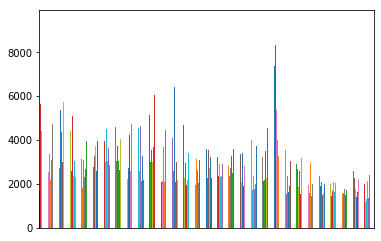

In [11]:
dates_count.plot.bar()
gca = plt.gca()
gca.axes.get_xaxis().set_visible(False)

del dates_count
gc.collect();

In [12]:
transactions[['day','month','year']] = transactions.date.str.split('.',expand=True)

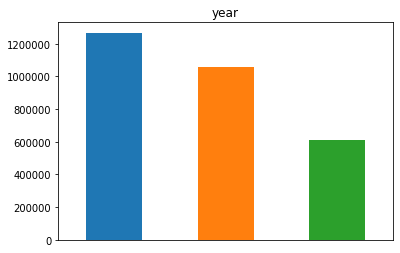

In [13]:
transactions.year.value_counts().sort_index().plot.bar(title='year')
gca = plt.gca()
gca.axes.get_xaxis().set_visible(False)

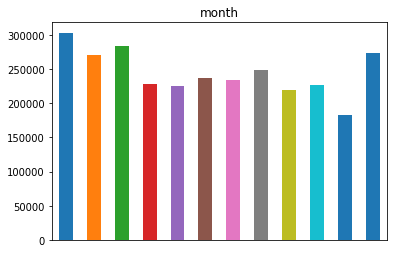

In [14]:
transactions.month.value_counts().sort_index().plot.bar(title='month')
gca = plt.gca()
gca.axes.get_xaxis().set_visible(False)

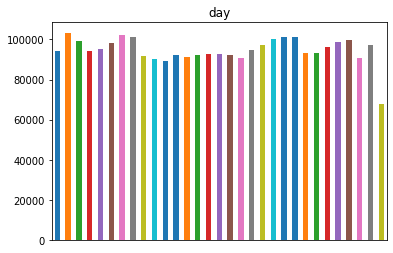

In [15]:
transactions.day.value_counts().sort_index().plot.bar(title='day')
gca = plt.gca()
gca.axes.get_xaxis().set_visible(False)

1. The training data has **Daily** time granularity
2. There is no obvious trend over the the number of recorders over daily time buckets.
3. There is obvious trend over yearly and monthly level. The records are decreased over years. The the number of transaction is larger from Dec to Mar. 
4. **Mean encocding** and **counts of records**, **sum of item counts** over year and month bucket should help with prediction.

### Dates Block Number

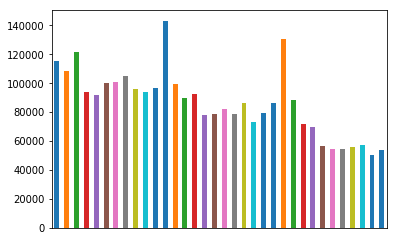

In [16]:
transactions['date_block_num'].value_counts().sort_index(ascending=True).plot.bar()
gca = plt.gca()
gca.axes.get_xaxis().set_visible(False)

#### Test Date Block Number and Date

In [17]:
date_block_num_max = transactions['date_block_num'].max()
year_month_max = transactions[transactions['date_block_num']==date_block_num_max][['year', 'month', 'date_block_num']].drop_duplicates()
print("maximum date block number: " + str(date_block_num_max))
year_month_max

maximum date block number: 33


,year,month,date_block_num
2882335,2015,10,33


### Item Id

In [18]:
item_value_counts = transactions['item_id'].value_counts()
print('min item counts: ' + str(item_value_counts.min()))
print('max item counts: ' + str(item_value_counts.max()))

min item counts: 1
max item counts: 31340


In [19]:
del item_value_counts
gc.collect()

122028

### Shop Id

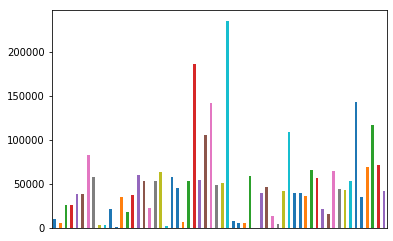

In [20]:
transactions['shop_id'].value_counts().sort_index(ascending=True).plot.bar()
gca = plt.gca()
gca.axes.get_xaxis().set_visible(False)

### Item and Shop Id

In [21]:
item_shop_values = transactions[['item_id', 'shop_id']].drop_duplicates()
item_shop_values_counts = transactions[['item_id', 'shop_id']].groupby(['item_id', 'shop_id']).size()
item_shop_values_counts.max()

867

In [22]:
del item_shop_values, item_shop_values_counts
gc.collect()

5347

### Possible Features
1. Target Encoding of of Year, Month, Day
2. Target encoding of shop id, item id.
2. Count of recoders, shops, items over year, month, daily buckets.
2. Lagged values of total shop counts, item counts, sales, recorders.
3. Average price of items over year month, daily buckets.
3. Lagged average price of items.
4. Total sales over year, month, daily buckets.
4. Lagged values of total sales.

## Feature Generation

### Generate Target

In [23]:
col_names = ['item_id', 'shop_id', 'year', 'month']
transactions['item_sale_day'] = transactions['item_price'] * transactions['item_cnt_day']
target = transactions[col_names + ['item_cnt_day']].dropna().groupby(col_names).sum().rename({'item_cnt_day': 'target'}, axis='columns')
transactions = transactions.join(target, on=col_names)
transactions.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_formatted,day,month,year,item_sale_day,target
0,02.01.2013,0,59,22154,999.000000,1.0,2013-01-02,02,01,2013,999.000000,1.0
1,03.01.2013,0,25,2552,899.000000,1.0,2013-01-03,03,01,2013,899.000000,0.0
2,05.01.2013,0,25,2552,899.000000,-1.0,2013-01-05,05,01,2013,-899.000000,0.0
3,06.01.2013,0,25,2554,1709.050049,1.0,2013-01-06,06,01,2013,1709.050049,1.0
4,15.01.2013,0,25,2555,1099.000000,1.0,2013-01-15,15,01,2013,1099.000000,1.0


In [24]:
del col_names, target
gc.collect();

### Item Category Id

In [25]:
transactions = transactions.join(items[['item_id', 'item_category_id']].set_index('item_id'), on='item_id')
transactions.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_formatted,day,month,year,item_sale_day,target,item_category_id
0,02.01.2013,0,59,22154,999.000000,1.0,2013-01-02,02,01,2013,999.000000,1.0,37
1,03.01.2013,0,25,2552,899.000000,1.0,2013-01-03,03,01,2013,899.000000,0.0,58
2,05.01.2013,0,25,2552,899.000000,-1.0,2013-01-05,05,01,2013,-899.000000,0.0,58
3,06.01.2013,0,25,2554,1709.050049,1.0,2013-01-06,06,01,2013,1709.050049,1.0,58
4,15.01.2013,0,25,2555,1099.000000,1.0,2013-01-15,15,01,2013,1099.000000,1.0,56


### Count of Records, shops, items, item categories ove monthly buckets.

In [26]:
col_names = ['shop_id', 'item_id', 'item_category_id']
bucket_col_names = {'date_block_num': 'month'}

lagged_feature_names = list()

for col_name in col_names:
    for bucket_col_name in bucket_col_names.keys():
        grouped = transactions[[col_name, bucket_col_name, "item_cnt_day", "item_sale_day"]].groupby([col_name, bucket_col_name])
        
        column_name_map = {
            'item_cnt_day': col_name + "_count_" + bucket_col_names[bucket_col_name],
            'item_sale_day': col_name + "_sale_" + bucket_col_names[bucket_col_name]
        }
        lagged_feature_names.extend(column_name_map.values())
        transactions_ = grouped.sum().rename(column_name_map, axis='columns')
        transactions = transactions.join(transactions_, on=[col_name, bucket_col_name])
        
print(lagged_feature_names)
transactions.head()

['shop_id_count_month', 'shop_id_sale_month', 'item_id_count_month', 'item_id_sale_month', 'item_category_id_count_month', 'item_category_id_sale_month']


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_formatted,day,month,year,item_sale_day,target,item_category_id,shop_id_count_month,shop_id_sale_month,item_id_count_month,item_id_sale_month,item_category_id_count_month,item_category_id_sale_month
0,02.01.2013,0,59,22154,999.000000,1.0,2013-01-02,02,01,2013,999.000000,1.0,37,2017.0,1633431.0,18.0,17982.000000,6094.0,2.845050e+06
1,03.01.2013,0,25,2552,899.000000,1.0,2013-01-03,03,01,2013,899.000000,0.0,58,8215.0,5376478.0,0.0,0.000000,287.0,4.059590e+05
2,05.01.2013,0,25,2552,899.000000,-1.0,2013-01-05,05,01,2013,-899.000000,0.0,58,8215.0,5376478.0,0.0,0.000000,287.0,4.059590e+05
3,06.01.2013,0,25,2554,1709.050049,1.0,2013-01-06,06,01,2013,1709.050049,1.0,58,8215.0,5376478.0,1.0,1709.050049,287.0,4.059590e+05
4,15.01.2013,0,25,2555,1099.000000,1.0,2013-01-15,15,01,2013,1099.000000,1.0,56,8215.0,5376478.0,2.0,2197.699951,268.0,2.331889e+05


### Price Stats of Items

In [27]:
grouped = transactions[col_names + ['date_block_num', "item_price"]].groupby(col_names + ['date_block_num'])
        
lagged_feature_names.append('item_price_mean_month')
lagged_feature_names.append('item_price_std_month')

transactions_ = grouped.mean().rename({'item_price': 'item_price_mean_month'}, axis='columns')
transactions = transactions.join(transactions_, on=col_names + ['date_block_num'])

transactions_ = grouped.std().rename({'item_price': 'item_price_std_month'}, axis='columns').fillna(0)
transactions = transactions.join(transactions_, on=col_names + ['date_block_num'])

transactions.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_formatted,day,month,year,...,target,item_category_id,shop_id_count_month,shop_id_sale_month,item_id_count_month,item_id_sale_month,item_category_id_count_month,item_category_id_sale_month,item_price_mean_month,item_price_std_month
0,02.01.2013,0,59,22154,999.000000,1.0,2013-01-02,02,01,2013,...,1.0,37,2017.0,1633431.0,18.0,17982.000000,6094.0,2.845050e+06,999.000000,0.0
1,03.01.2013,0,25,2552,899.000000,1.0,2013-01-03,03,01,2013,...,0.0,58,8215.0,5376478.0,0.0,0.000000,287.0,4.059590e+05,899.000000,0.0
2,05.01.2013,0,25,2552,899.000000,-1.0,2013-01-05,05,01,2013,...,0.0,58,8215.0,5376478.0,0.0,0.000000,287.0,4.059590e+05,899.000000,0.0
3,06.01.2013,0,25,2554,1709.050049,1.0,2013-01-06,06,01,2013,...,1.0,58,8215.0,5376478.0,1.0,1709.050049,287.0,4.059590e+05,1709.050049,0.0
4,15.01.2013,0,25,2555,1099.000000,1.0,2013-01-15,15,01,2013,...,1.0,56,8215.0,5376478.0,2.0,2197.699951,268.0,2.331889e+05,1099.000000,0.0


### Stats of Items sales and counts

In [28]:
grouped = transactions[col_names + ['date_block_num', "item_cnt_day", "item_sale_day"]].groupby(col_names + ['date_block_num'])
        
lagged_feature_names.extend(['item_shop_cnt_sum_month', 'item_shop_cnt_std_month', "item_shop_sale_sum_month", "item_shop_sale_std_month"])

column_name_map = {
    'item_cnt_day': 'item_shop_cnt_sum_month',
    'item_sale_day': "item_shop_sale_sum_month"
}
transactions_ = grouped.sum().rename(column_name_map, axis='columns')
transactions = transactions.join(transactions_, on=col_names + ['date_block_num'])

column_name_map = {
    'item_cnt_day': 'item_shop_cnt_std_month',
    'item_sale_day': "item_shop_sale_std_month"
}
transactions_ = grouped.std().rename(column_name_map, axis='columns').fillna(0)
transactions = transactions.join(transactions_, on=col_names + ['date_block_num'])

transactions.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_formatted,day,month,year,...,item_id_count_month,item_id_sale_month,item_category_id_count_month,item_category_id_sale_month,item_price_mean_month,item_price_std_month,item_shop_cnt_sum_month,item_shop_sale_sum_month,item_shop_cnt_std_month,item_shop_sale_std_month
0,02.01.2013,0,59,22154,999.000000,1.0,2013-01-02,02,01,2013,...,18.0,17982.000000,6094.0,2.845050e+06,999.000000,0.0,1.0,999.000000,0.000000,0.000000
1,03.01.2013,0,25,2552,899.000000,1.0,2013-01-03,03,01,2013,...,0.0,0.000000,287.0,4.059590e+05,899.000000,0.0,0.0,0.000000,1.414214,1271.378052
2,05.01.2013,0,25,2552,899.000000,-1.0,2013-01-05,05,01,2013,...,0.0,0.000000,287.0,4.059590e+05,899.000000,0.0,0.0,0.000000,1.414214,1271.378052
3,06.01.2013,0,25,2554,1709.050049,1.0,2013-01-06,06,01,2013,...,1.0,1709.050049,287.0,4.059590e+05,1709.050049,0.0,1.0,1709.050049,0.000000,0.000000
4,15.01.2013,0,25,2555,1099.000000,1.0,2013-01-15,15,01,2013,...,2.0,2197.699951,268.0,2.331889e+05,1099.000000,0.0,1.0,1099.000000,0.000000,0.000000


In [29]:
del transactions_, bucket_col_names, grouped
gc.collect();

### Lagged Count of Shops, items, item categories over monthly buckets

In [30]:
shift_range = [1, 2, 3, 4, 5, 6, 12]
index_col_names = col_names + ['date_block_num']

transactions = downcast_dtypes(transactions)

## transactions data is too large, we generate lagged features by small batch.
## split transactions data into small chunks by data_block_num
## and process each chunk separately

shop_ids = transactions['shop_id'].drop_duplicates().values.tolist()

is_first_chunk = True

for shop_id in tn(shop_ids):
    chunked = transactions[transactions['shop_id'] == shop_id].copy()
    
    for shift in shift_range:
        tran_shift = chunked[index_col_names + lagged_feature_names].copy()
        tran_shift.drop_duplicates(subset=index_col_names, inplace=True)
        
        tran_shift['date_block_num'] = tran_shift['date_block_num'] + shift
    
        foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lagged_feature_names else x
        tran_shift = tran_shift.rename(columns=foo)
        
        # Don't use old data from year 2013
        chunked = chunked[chunked['date_block_num'] >= 12] 
        # Don't use data beyond 34 date_block_num
        tran_shift = tran_shift[(tran_shift['date_block_num'] <= 34) & (tran_shift['date_block_num'] >= 12)] 
        
        tran_shift.set_index(index_col_names, inplace=True)
        chunked.set_index(index_col_names, inplace=True)

        chunked = chunked.join(tran_shift, how='left') 
        chunked.reset_index(inplace=True)
        gc.collect()
        # print(chunked.columns)
    
    if chunked.shape[0] == 0:
        continue;
    append_save_file(chunked, train_transactions_path, is_first_chunk)
    is_first_chunk = False
        
del tran_shift, chunked, is_first_chunk, transactions
gc.collect()

8

## Prepare Train and Test Data

In [31]:
train_data = pd.read_csv(train_transactions_path)
train_data = downcast_dtypes(train_data)

print(train_data.columns.tolist())
print("\n")
print(train_data.shape)

['shop_id', 'item_id', 'item_category_id', 'date_block_num', 'date', 'item_price', 'item_cnt_day', 'date_formatted', 'day', 'month', 'year', 'item_sale_day', 'target', 'shop_id_count_month', 'shop_id_sale_month', 'item_id_count_month', 'item_id_sale_month', 'item_category_id_count_month', 'item_category_id_sale_month', 'item_price_mean_month', 'item_price_std_month', 'item_shop_cnt_sum_month', 'item_shop_sale_sum_month', 'item_shop_cnt_std_month', 'item_shop_sale_std_month', 'shop_id_count_month_lag_1', 'shop_id_sale_month_lag_1', 'item_id_count_month_lag_1', 'item_id_sale_month_lag_1', 'item_category_id_count_month_lag_1', 'item_category_id_sale_month_lag_1', 'item_price_mean_month_lag_1', 'item_price_std_month_lag_1', 'item_shop_cnt_sum_month_lag_1', 'item_shop_cnt_std_month_lag_1', 'item_shop_sale_sum_month_lag_1', 'item_shop_sale_std_month_lag_1', 'shop_id_count_month_lag_2', 'shop_id_sale_month_lag_2', 'item_id_count_month_lag_2', 'item_id_sale_month_lag_2', 'item_category_id_coun

In [32]:
index_column_names = ['shop_id', 'item_id', 'date_block_num']

train_data.drop(columns=['date', 'date_formatted', 'day', 'year', 'item_sale_day', 'item_cnt_day'], inplace=True)
train_data.drop_duplicates(subset=index_column_names, inplace=True)

train_data = sklearn.utils.shuffle(train_data)

print(train_data.shape)
train_data.dtypes

(921400, 103)


shop_id                                  int32
item_id                                  int32
item_category_id                         int32
date_block_num                           int32
item_price                             float32
month                                    int32
target                                 float32
shop_id_count_month                    float32
shop_id_sale_month                     float32
item_id_count_month                    float32
item_id_sale_month                     float32
item_category_id_count_month           float32
item_category_id_sale_month            float32
item_price_mean_month                  float32
item_price_std_month                   float32
item_shop_cnt_sum_month                float32
item_shop_sale_sum_month               float32
item_shop_cnt_std_month                float32
item_shop_sale_std_month               float32
shop_id_count_month_lag_1              float32
shop_id_sale_month_lag_1               float32
item_id_count

### Drop Columns

In [34]:
columns_to_drop = [
    'item_price',
    'shop_id_count_month', 'shop_id_sale_month',
    'item_id_count_month', 'item_id_sale_month',
    'item_category_id_count_month', 'item_category_id_sale_month',
    'item_price_mean_month', 'item_price_std_month',
    'item_shop_cnt_sum_month', 'item_shop_cnt_std_month',
    'item_shop_sale_sum_month', 'item_shop_sale_std_month'
]

train_data.drop(columns_to_drop, axis='columns', inplace=True)
train_data.dtypes

shop_id                                  int32
item_id                                  int32
item_category_id                         int32
date_block_num                           int32
month                                    int32
target                                 float32
shop_id_count_month_lag_1              float32
shop_id_sale_month_lag_1               float32
item_id_count_month_lag_1              float32
item_id_sale_month_lag_1               float32
item_category_id_count_month_lag_1     float32
item_category_id_sale_month_lag_1      float32
item_price_mean_month_lag_1            float32
item_price_std_month_lag_1             float32
item_shop_cnt_sum_month_lag_1          float32
item_shop_cnt_std_month_lag_1          float32
item_shop_sale_sum_month_lag_1         float32
item_shop_sale_std_month_lag_1         float32
shop_id_count_month_lag_2              float32
shop_id_sale_month_lag_2               float32
item_id_count_month_lag_2              float32
item_id_sale_

### Make Test Data

In [35]:
TEST_DATE_BLOCK_NUM = 34

dates = train_data['date_block_num']
test_from_train = train_data[dates == TEST_DATE_BLOCK_NUM]

test_from_train.set_index(['shop_id', 'item_id'], inplace=True)
test_data = test.join(test_from_train, on=['shop_id', 'item_id'])

count_nan = test_data.shape[0] - test_data['date_block_num'].count()
print('number of test data points that do not have correponding training data: ' + str(count_nan))

test_data.drop(['target'], axis='columns', inplace=True)

number of test data points that do not have correponding training data: 214200


In [36]:
del test_from_train, count_nan

### Make Validation Data

In [37]:
valid_data = train_data[dates == (TEST_DATE_BLOCK_NUM - 1)]

### Make Training Data

In [38]:
training = train_data[dates < (TEST_DATE_BLOCK_NUM - 1)]

### Save Training, Validation and Testing Data

In [ ]:
training_path = os.path.join(VALIDATION_FOLDER, "train.csv")
validation_path = os.path.join(VALIDATION_FOLDER, "test.csv")

train_data_path = os.path.join(SUBMISSION_FOLDER, "train.csv")
test_data_path = os.path.join(SUBMISSION_FOLDER, "test.csv")

training.to_csv(training_path, index=False)
valid_data.to_csv(validation_path, index=False)
train_data.to_csv(train_data_path, index=False)
test_data.to_csv(test_data_path, index=False)